# 🔮 What if we could predict when a bunch of cyclists would be at bunch of locations in London?


![Dall-e prompt: "A data scientist training a predictive model (tree based approach) on a dataset that describes the santander cycles of London"](../images/img2.png)

Insight from such a model could be extremely valuable to individuals or businesses small or large, private and public sector.
For example:

 - Sell / advertise to the cyclists
     - Food & drink
     - Upgrade to a 'real' bike
     - Cycling gear and accessories
     - Cycling clubs and communities
     - Maintenance services
     - Apps: Strava, Komoot, Mapmyride
 - Offer services
     - Alternative bike rental 
     - Alternative transportation 
        - Taxis if its about to rain?
     - Route planning assistance / tourist routes & guides
 - Enhance safety and experience
     - Real-time information on road conditions or closures
     - Navigation assistance to avoid congested areas
 - Support sustainability initiatives
     - Partner with eco-friendly brands
     - Promote green riding habits and rewards

For TFL:
- Demand on the network: Redistributing bikes across the stations to minimise shortages (it is assumed there is an advanced capability in this space already)
- Urban Planning and Infrastructure Development: By analyzing the most frequented routes and times, city planners can identify where to expand bike lanes, install new bike racks, or improve existing cycling infrastructure.
- Traffic Management: Understanding peak cycling times and popular routes can help in managing traffic flow and reducing congestion, especially during rush hours.
- Planned maintenance: Forecast quiet windows to maintain parts of the network


### 💼 Business Value Proposition

Let's focus on a use case for the launch of a rival bike sharing brand, to contend with Lime, HumanForest, Dott, Tier as well as the original scheme of whose data we are investigating, Santander cycles.

For our launch, we want to:
- Deploy brand ambassadors to distribute literature
    - 🔑: Predict the hours with peak load at the busiest stations
- Profile demand for a trial launch on a few stations
    - 🔑: Get the numbers correct at all stations - each prediction equally as important


In [47]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error

import os

os.chdir("..")

from src.models.V0 import model_rf, model_gbm
from src.models.VBaseline import GroupMeanRegressor as vB_model

sns.set_theme(style="whitegrid")

## 🚲 Data Preprocessing Steps

We will model hourly `hire` counts explored in the previous notebook. 
We'll only use the start times of journeys, ignoring the destination and arrival time - of course in future iterations of this modelling exercise we would want to include this valuable information


### 1. Expand the grid 
As the SQL aggregation will only bring back hours with a hire present, we'll be dropping a lot of zero hours.
The function `expand_hourly_counts` in `src/data/transform/py` imputes zero hours between active dates for each station. 
> A clunky and implementation, ripe for refactoring

### 2. Feature engineering

A few lightweight preprocessing steps have been taken on the whole dataset, with care taken to ensure no features are [leaky](https://scikit-learn.org/stable/common_pitfalls.htmldata-leakage)


### 3. Simplifications

We'll just use the three stations we found during the EDA stage for this first version of the model

In [3]:
!python src/data/transform.py

Added 7044341 (198.6%)
Expanded hourly counts have been saved successfully.



Expanding hourly counts: 100%|██████████| 822/822 [05:10<00:00,  2.64it/s]


In [2]:
!python src/data/features.py

Some key additional data sources to be added in future iterations:
- Information on tube, bus strikes
- School holidays
- Major roadworks
- Weather data

In [8]:
df = pd.read_parquet("data/hourly_hire_counts_fe.parquet")

dates_to_remove = pd.to_datetime(
    [
        "2022-09-18",
        "2022-09-19",
        "2022-09-20",
        "2022-09-21",
        "2022-09-22",
        "2022-09-23",
        "2022-09-24",
        "2022-09-25",
        "2022-09-26",
        "2022-10-30",
        "2022-10-31",
        "2022-11-01",
        "2022-11-02",
        "2022-11-03",
        "2022-11-04",
        "2022-11-05",
        "2022-11-06",
        "2022-11-07",
        "2022-12-25",
        "2022-12-26",
        "2022-12-27",
        "2022-12-28",
        "2022-12-29",
        "2022-12-30",
        "2022-12-31",
        "2023-01-01",
        "2023-01-02",
    ]
)

df = df[~df.start_hour.dt.date.isin(dates_to_remove.date)]

df = df[
    df.start_station_name.isin(
        ["Soho Square , Soho", "Sidney Road, Stockwell", "Cheapside, Bank"]
    )
]

## 🧪 Experiment 

We'll use a basic time-series split to create a single train and single test set for today, in lieu of a full [TS/CV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html). 
A great sci-kit learn [article](https://scikit-learn.org/stable/auto_examples/applications/plot_time_series_lagged_features.htmlproper-next-hour-forecasting-evaluation) that uses a similar dataset to ours discusses the preferred approach.

In [9]:
df = df.sort_values("start_hour")

# Define a cutoff date for splitting the data
cutoff_date = df["start_hour"].quantile(0.9)

train_df = df[df["start_hour"] <= cutoff_date].copy()
test_df = df[df["start_hour"] > cutoff_date].copy()

In [10]:
test_df.start_hour.min(), test_df.start_hour.max()

(Timestamp('2022-10-18 04:00:00+0000', tz='UTC'),
 Timestamp('2023-01-15 22:00:00+0000', tz='UTC'))

In [11]:
X_train, y_train = train_df.drop("hire_count", axis=1), train_df["hire_count"]
X_test, y_test = test_df.drop("hire_count", axis=1), test_df["hire_count"]

##  🤖 Models
 
 The primary goal for this section is to establish a baseline prediction using a tree-based approach. For the initial version (V0), we have selected two models: Random Forest and Histogram-based Gradient Boosting Regression Tree (HistGradientBoostingRegressor).
 
Random Forest:
 - Handles non-linear relationships: Random Forest can manage the non-linear interactions between features and the target, which is typical in time series data.
 - Robust to outliers: The model's ensemble nature makes it less sensitive to outliers, which are common in real-world datasets.
 - Implicit feature interaction: It can automatically capture complex interactions between features without manual feature engineering.
 - Feature importance: Provides insights into the significance of different predictors in estimating the hire counts. (Not used in this notebook)
 - Good default performance: Often delivers strong results with default hyperparameters, making it an excellent candidate for a baseline model.
 
 Justifications for HistGradientBoostingRegressor:
 - Speed and scalability: Designed to be faster and suitable for larger datasets, especially when dealing with a significant number of categorical features.
 - Handling sparse data: Efficient with datasets that have missing values or a large number of categories in categorical features.
 - Gradient boosting advantage: By focusing on errors of previous trees, it iteratively improves the model's performance, which can be beneficial for time series forecasting.
 - Monotonic constraints: Ability to enforce monotonic relationships between certain features and the target, which can be useful if domain knowledge suggests such constraints.
 
 Both models will utilize time-related features directly, rather than decomposing the time series:
 - Time of day, day of week, and week of year: These categorical features are included to capture the cyclical and seasonal patterns inherent in the data, allowing the models to leverage periodicity for more accurate predictions.
 
 We will not use lagged features in this baseline model, as our focus is not on forecast horizons but rather on capturing the immediate patterns in the data.
 
 The station will be used as a feature, acknowledging that this limits our model to making predictions only for the existing stations and not for new ones.

 


### 🚀 Training 

In [12]:
# Baseline model
vb = vB_model()
vb.fit(X_train, y_train)
y_pred_baseline = vb.predict(X_test)

# RF model
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

# GBM
model_gbm.fit(X_train, y_train)
y_pred_gbm = model_gbm.predict(X_test)


## 🔍 Evaluation 
 
 We'll track two metrics:
 
 - Mean squared error (MSE):
     - For the brand ambassadors business case where we value getting high demand predictions right, MSE emphasizes larger errors more than smaller ones, which can be important when overestimating demand is more costly than underestimating it, penalising higher footfall stations more than lower.

 - Mean absolute scaled error (MASE):
     - MASE is scale-independent and is particularly useful when comparing forecast accuracy across different data sets. We'll use it to adjust scale across the individual stations
     - It is less sensitive to large errors than MSE, which can provide a more balanced view of model performance, especially when outliers are present.
     - MASE is also interpretable as it expresses forecast error as a ratio of the mean absolute error of the naive forecast (no change from one period to the next).
     - For the business cases where we are interested in getting a balanced view of demand across all stations, regardless of their individual scale, MASE provides a consistent measure. This is particularly relevant when evaluating the performance of our model on a diverse set of stations with varying levels of bike traffic.


In [17]:
def evaluate_overfitting(model, X_train, y_train, X_test, y_test, model_name):
    # Calculate overall metrics for the test set
    y_test_pred = model.predict(X_test)
    test_mse = mean_squared_error(y_test, y_test_pred)

    # Calculate overall metrics for the training set to check for overfitting
    y_train_pred = model.predict(X_train)
    train_mse = mean_squared_error(y_train, y_train_pred)

    # Compare the metrics of the training and test sets
    print(f"{model_name} - Training MSE: {train_mse}")
    print(f"{model_name} - Test MSE: {test_mse}")

    # Check for overfitting
    if test_mse > train_mse:
        print(f"The {model_name} model may be overfitting to the training data.")
    else:
        print(f"The {model_name} model does not appear to be overfitting.")

evaluate_overfitting(model_rf, X_train, y_train, X_test, y_test, "RF")
print("")
evaluate_overfitting(model_gbm, X_train, y_train, X_test, y_test, "GBM")


RF - Training MSE: 4.2270754328292375
RF - Test MSE: 8.06965339585033
The RF model may be overfitting to the training data.

GBM - Training MSE: 7.5100664963256705
GBM - Test MSE: 5.910295264288678
The GBM model does not appear to be overfitting.


In [43]:
def mean_absolute_scaled_error(y_true, y_pred, y_train):
    """A simple implementation of MASE that ignores seasonality. See  FPP for details"""
    n = len(y_train)
    d = np.abs(np.diff(y_train)).sum() / (n - 1)
    errors = np.abs(y_true - y_pred)
    return errors.mean() / d


def evaluate_model_performance(y_true, y_pred, y_train):
    mase = mean_absolute_scaled_error(y_true, y_pred, y_train)
    mse = mean_squared_error(y_true, y_pred)
    return {"MASE": mase, "MSE": mse}


def calculate_performance_metrics(df, groupby_cols, y_train_df):
    performance_metrics = []
    for group_keys, group in df.groupby(groupby_cols):
        y_true = group["hire_count"]
        y_pred_rf = group["predicted_hire_count_rf"]
        y_pred_gbm = group["predicted_hire_count_gbm"]
        y_pred_baseline = group["predicted_hire_count_baseline"]

        if isinstance(group_keys, tuple):
            station_name = group_keys[1]
        else:
            station_name = group_keys

        y_train = y_train_df[y_train_df["start_station_name"] == station_name][
            "hire_count"
        ]

        if not y_train.empty:
            metrics_rf = evaluate_model_performance(y_true, y_pred_rf, y_train)
            metrics_gbm = evaluate_model_performance(y_true, y_pred_gbm, y_train)
            metrics_baseline = evaluate_model_performance(
                y_true, y_pred_baseline, y_train
            )

            metrics = {
                "Station": station_name,
                "RF_MASE": metrics_rf["MASE"],
                "RF_MSE": metrics_rf["MSE"],
                "GBM_MASE": metrics_gbm["MASE"],
                "GBM_MSE": metrics_gbm["MSE"],
                "Baseline_MASE": metrics_baseline["MASE"],
                "Baseline_MSE": metrics_baseline["MSE"],
            }

            if isinstance(group_keys, tuple):
                metrics["Day"] = group_keys[0]

            performance_metrics.append(metrics)
    return performance_metrics


# Add predictions to the test dataframe
test_df["predicted_hire_count_rf"] = y_pred_rf
test_df["predicted_hire_count_gbm"] = y_pred_gbm
test_df["predicted_hire_count_baseline"] = y_pred_baseline

# Calculate MASE and MSE for each station and return them as a dataframe
performance_metrics = calculate_performance_metrics(
    test_df, "start_station_name", train_df
)
performance_df = pd.DataFrame(performance_metrics)
performance_df.set_index("Station", inplace=True)

# Calculate MASE and MSE for each day and station and return them as a dataframe
daily_performance_metrics = calculate_performance_metrics(
    test_df, [test_df.start_hour.dt.date, "start_station_name"], train_df
)
daily_performance_df = pd.DataFrame(daily_performance_metrics)
daily_performance_df.set_index(["Day", "Station"], inplace=True)

# Calculate overall performance metrics for each model
overall_performance_rf = evaluate_model_performance(
    test_df["hire_count"], test_df["predicted_hire_count_rf"], train_df["hire_count"]
)
overall_performance_gbm = evaluate_model_performance(
    test_df["hire_count"], test_df["predicted_hire_count_gbm"], train_df["hire_count"]
)
overall_performance_baseline = evaluate_model_performance(
    test_df["hire_count"],
    test_df["predicted_hire_count_baseline"],
    train_df["hire_count"],
)

overall_performance = {
    "RF_MASE": overall_performance_rf["MASE"],
    "RF_MSE": overall_performance_rf["MSE"],
    "GBM_MASE": overall_performance_gbm["MASE"],
    "GBM_MSE": overall_performance_gbm["MSE"],
    "Baseline_MASE": overall_performance_baseline["MASE"],
    "Baseline_MSE": overall_performance_baseline["MSE"],
}

overall_performance_df = pd.DataFrame([overall_performance], index=["Overall"])


In [44]:
# Highlight the GBM_MASE and GBM_MSE columns in performance_df
def highlight_gbm_columns(val):
    color = 'green' if (val.name == 'GBM_MASE' or val.name == 'GBM_MSE') else ''
    return ['background-color: {}'.format(color)] * len(val)


overall_performance_df = overall_performance_df.style.apply(highlight_gbm_columns, axis=0)
overall_performance_df

,RF_MASE,RF_MSE,GBM_MASE,GBM_MSE,Baseline_MASE,Baseline_MSE
Overall,0.496504,8.069653,0.445461,5.910295,0.763574,13.699187


In [45]:
performance_df = performance_df.style.apply(highlight_gbm_columns, axis=0)
performance_df


,RF_MASE,RF_MSE,GBM_MASE,GBM_MSE,Baseline_MASE,Baseline_MSE
Station,,,,,,
"Cheapside, Bank",0.737047,9.163458,0.664933,6.864304,1.341062,22.019856
"Sidney Road, Stockwell",0.778919,1.718772,0.708330,1.182888,0.948834,1.727225
"Soho Square , Soho",0.867430,13.319359,0.770992,9.678206,1.241671,17.336582


The GBM model performs best on all metrics, for all stations.

### 🧪 Residual Diagnostics
We'll (very) briefly look at some residuals

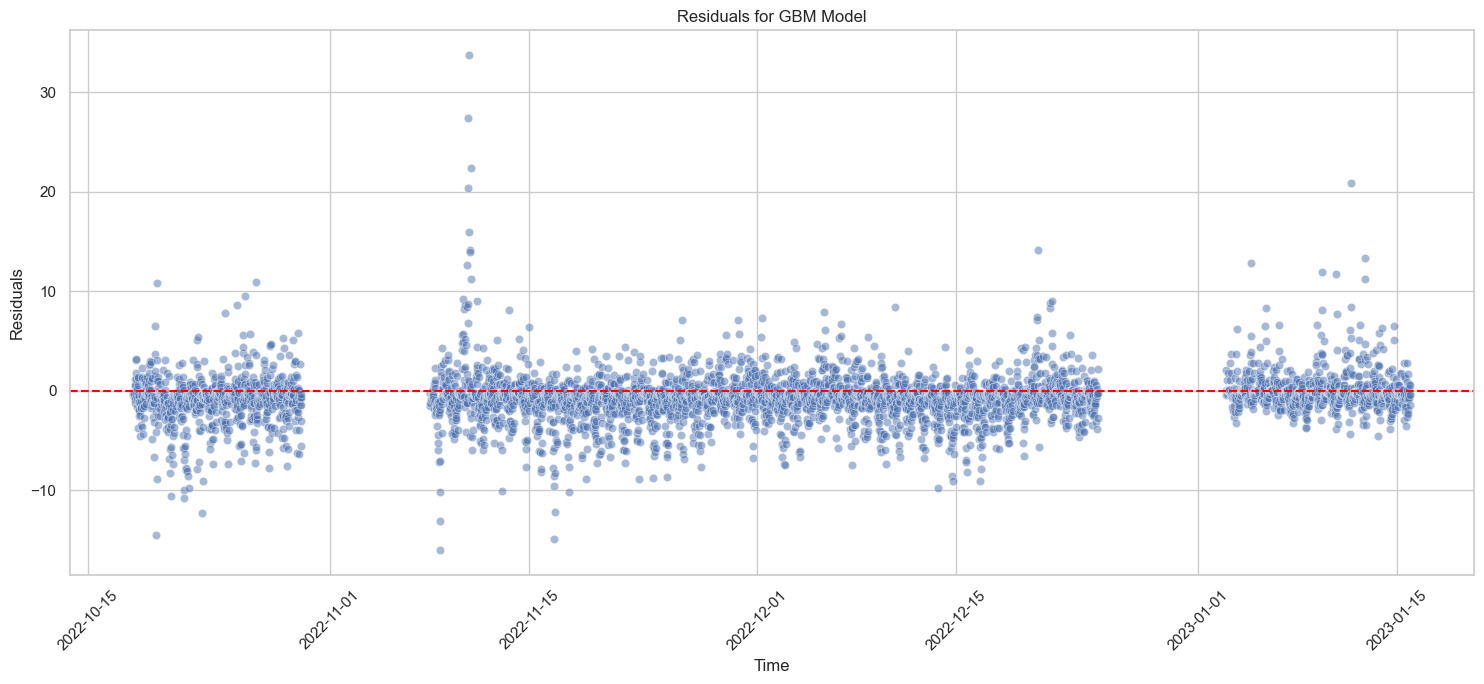

In [48]:
# Calculate residuals for the GBM model
test_df["residuals_gbm"] = test_df["hire_count"] - test_df["predicted_hire_count_gbm"]

# Plot residuals
plt.figure(figsize=(15, 7))
sns.scatterplot(data=test_df, x="start_hour", y="residuals_gbm", alpha=0.5)
plt.axhline(0, color="red", linestyle="--")
plt.title("Residuals for GBM Model")
plt.xlabel("Time")
plt.ylabel("Residuals")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In an earlier iteration of this plot, we diagnosed some missing data that can be seen to be removed from the above

> Not done: Further residual diagnostics. Check for seasonality and trend left over

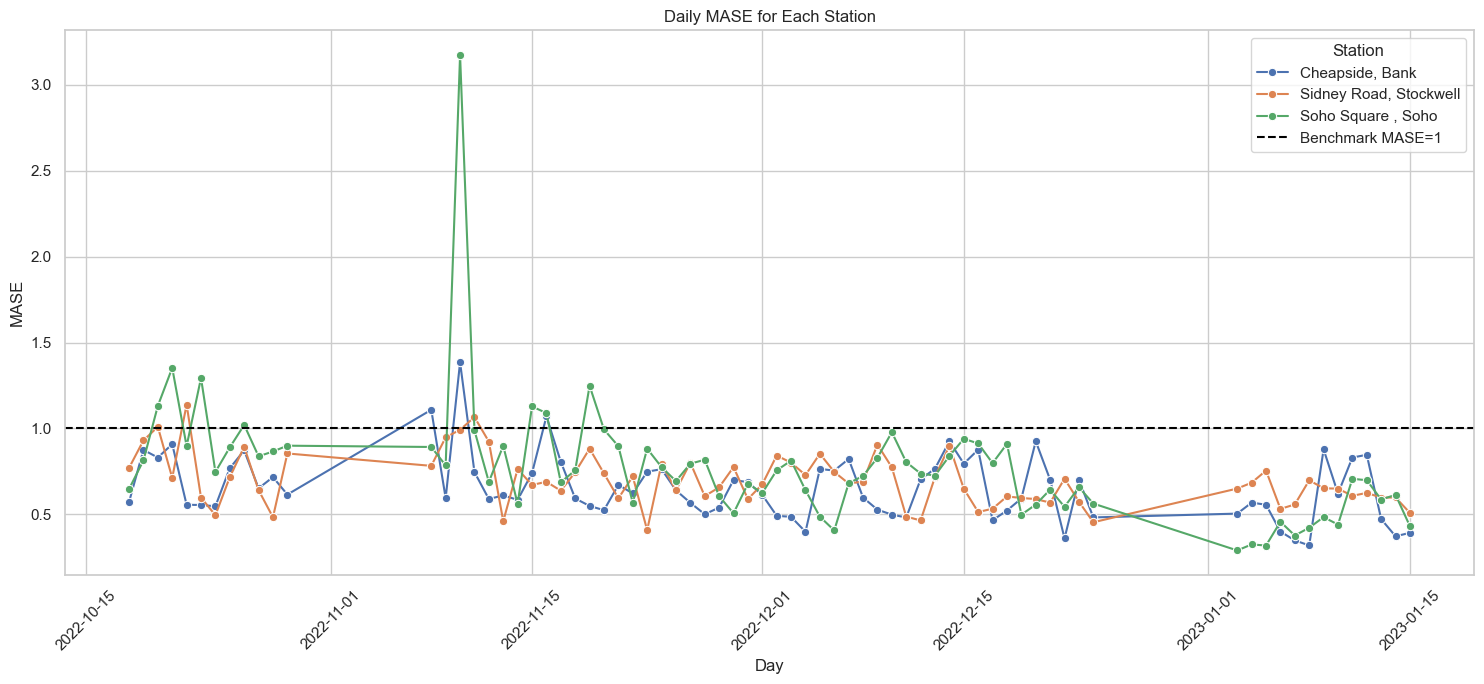

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(15, 7))
sns.lineplot(
    data=daily_performance_df.reset_index(),
    x="Day",
    y="GBM_MASE",
    hue="Station",
    marker="o",
)
plt.axhline(1, color="black", linestyle="--", label="Benchmark MASE=1")
plt.title("Daily MASE for Each Station")
plt.xlabel("Day")
plt.ylabel("MASE")
plt.legend(title="Station")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

> Used this plot to diagnose missing data that needed to be removed (see top of notebook)

 A MASE less than 1 indicates that the model performs better than the naive benchmark.

## 📈 A view of model predictions

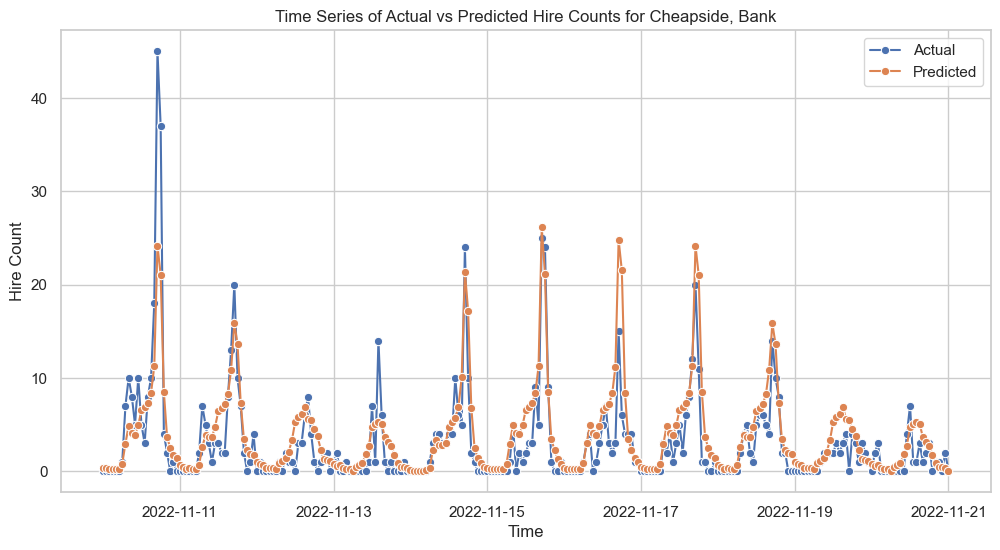

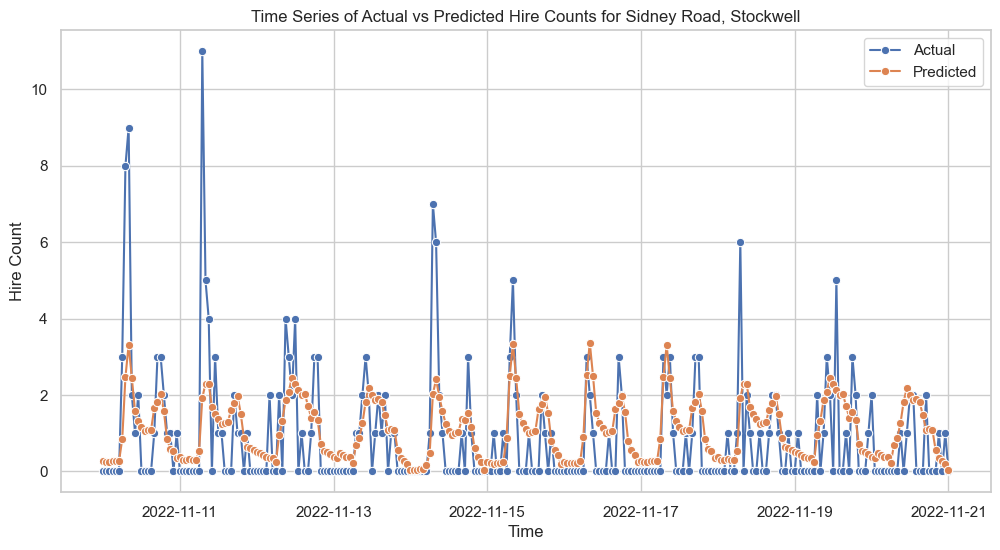

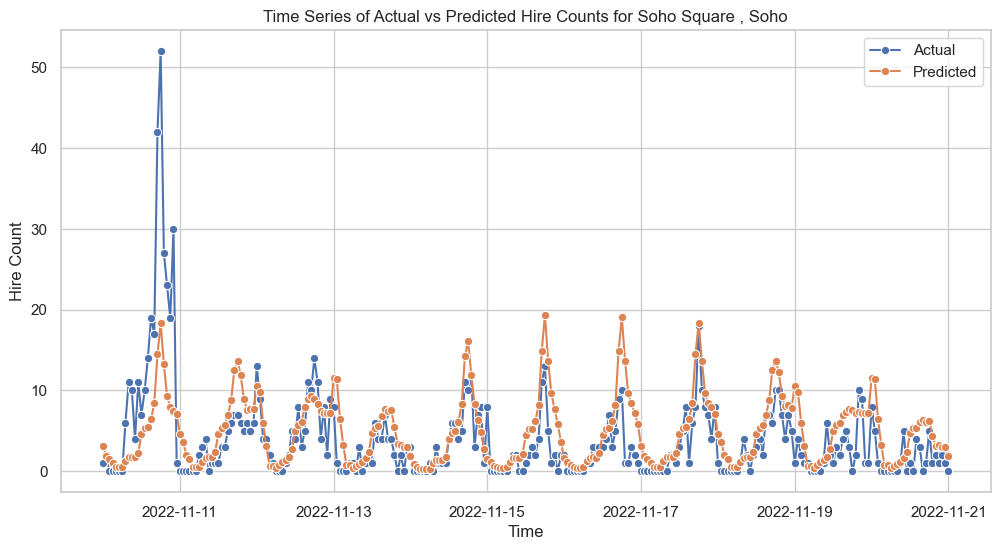

In [28]:
_test_df = test_df[test_df.start_hour.between("2022-11-10", "2022-11-21")].copy()

# Plotting the actual vs predicted hire counts for each station
for station in test_df["start_station_name"].unique():
    plt.figure(figsize=(12, 6))
    station_df = _test_df[_test_df["start_station_name"] == station]
    sns.lineplot(
        data=station_df, x="start_hour", y="hire_count", label="Actual", marker="o"
    )
    sns.lineplot(
        data=station_df,
        x="start_hour",
        y="predicted_hire_count_gbm",
        label="Predicted",
        marker="o",
    )
    plt.title(f"Time Series of Actual vs Predicted Hire Counts for {station}")
    plt.xlabel("Time")
    plt.ylabel("Hire Count")
    plt.legend()
    plt.show()

> 2022-11-10 was an underground strike. This data would be a clear enhancement to the model
https://en.wikipedia.org/wiki/London_Underground_strikes


## 📉 Modelling approach so far and next steps

The current modelling approach has successfully integrated a basic time series ML approach using seasonal features and a single station feature.

> Depending on the context of the business situation, this may well provide a huge amount of value, especially if the starting point is zero.

Comparison of actual vs predicted hire counts is a good starting point for diagnosing the model's performance. However, to further improve the model, the following steps could be taken:

1. Further model Evaluation:
    - Implement cross-validation to assess the model's performance across different time periods

2. Use the full dataset
    - All stations

3. Features, features, features:
    - Other than ease of implementation, one of the main value add of a ML approach against a classical time series approaches is the ease of including additional features. We could add:
        - Trips API to get expected travel time. Even add actual vs expected gives insight into tourist vs commuter; a station with lots of people taking 60 mins to make a 5 minute trip = tourists.
    - Incorporate weather data (temperature, precipitation, wind speed) as these factors can significantly affect bike hire patterns.
    - Consider adding public transportation strike days as a feature, as these events can lead to increased bike hires.
    - Explore lag features and rolling window statistics to capture temporal dependencies in the data.

5. Explore different models:
    - Compare to classical time series decomposition
    - We have a large dataset - could use a Neural network approach - traditional RNN/ LSTM, or even Transformers are used these days


# 🏭 Putting it into production:

I won't regurgitate the MLOps playbook here, but in the context of our data, the key concerns:

- Code written in a few hours:
    - Many bugs, early version of code

- Time series; target variable leakage
    - Always need to be careful here. E.G if we start to use weather data as a feature, are we making sure we are measuring and understanding performance using weather data that would be available at inference time? 

- Data quality of source:
    - Given the gaps in the data seen, the variety of source files in the original TFL source, we should be concerned with quality and consistency of the data
        - Data quality measures built into pipeline
        - Implement robust logging to ensure we are tracking data through the pipeline
        
- Performance monitoring and alerting
    - MLOps tools have inbuilt solutions to help here



# 🚳 Not done:

- Explored feature importance: This initial modelling approach was a quickly implemented time series decomposition with a single feature of station name. It would be useful to understand the relative value of these features, comparing the TS features to a seasonal decomposition
- Clustering model on trips and /or stations:
    - Trips: we have speculated that there are at least two groups in commuters vs tourists. A segmentation to explore different trip purposes would add a lot of value
    - Stations: we saw in the first notebook an obvious grouping

